Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [1]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [2]:
MIN_ROWS = 2
MAX_ROWS = 10
MIN_K = 2
MAX_K = MAX_ROWS*2
N_GAMES = 100

## The *Nim* and *Nimply* classes

In [3]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [8]:
class Nim:
    def __init__(self, num_rows: int, k: int = sys.maxsize) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def final_stage(self) -> bool:
        return self._finalstage

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [5]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, min(state._k, state._rows[row]))
    return Nimply(row, num_objects)


In [6]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [7]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [6]:
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)

def advanced_nim_sum(state: Nim) -> int:
    mex = [x % (state._k + 1) for x in state.rows]
    #print(mex)
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in mex])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)

def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        if raw._k < ply.num_objects:
            continue
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        # cooked["possible_moves"][ply] = nim_sum(tmp)
        cooked["possible_moves"][ply] = advanced_nim_sum(tmp)
        
    return cooked

def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
    if not spicy_moves:
        ply = pure_random(state)
    else:
        ply = random.choice(spicy_moves)
        
    return ply


## Evolutionary Strategy

## Oversimplified match

analyzing for k=2
	analyzing for #rows=2...
	analyzing for #rows=3...
	analyzing for #rows=4...
	analyzing for #rows=5...
	analyzing for #rows=6...
	analyzing for #rows=7...
	analyzing for #rows=8...
	analyzing for #rows=9...


FileNotFoundError: [Errno 2] No such file or directory: 'nim_data/k=2.npy'

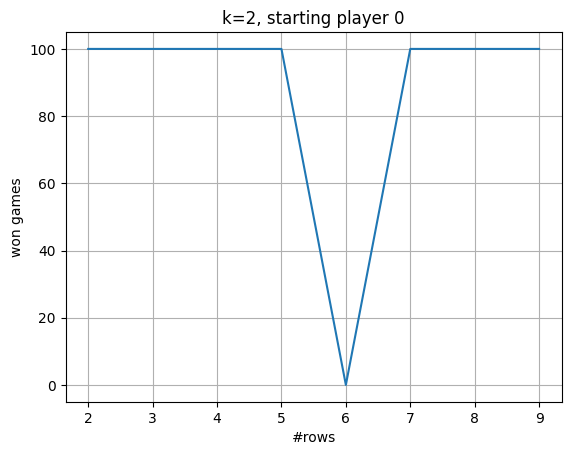

In [12]:
strategy = (optimal, optimal)
x = [i for i in range(MIN_ROWS, MAX_ROWS)]
p0 = np.empty(MAX_ROWS - MIN_ROWS, dtype=int)
p1 = np.empty(MAX_ROWS - MIN_ROWS, dtype=int)

wins = [0, 0]
# for i in range(1):
#     nim = Nim(4, 2)
#     print(f"init : {nim}")
#     player = 0
#     while nim:
#         ply = strategy[player](nim)
#         print(f"ply: player {player} plays {ply}")
#         nim.nimming(ply)
#         print(f"status: {nim}")
#         player = 1 - player
#     print(f"status: Player {player} won!")

for k in range(MIN_K, MAX_K):
    print(f'analyzing for k={k}')
    for n_rows in range(MIN_ROWS, MAX_ROWS):
        print(f'\tanalyzing for #rows={n_rows}...')
        wins = [0, 0]
        for i in range(N_GAMES):
            nim = Nim(n_rows, k)
            #print(f"init : {nim}")
            player = 0
            while nim:
                ply = strategy[player](nim)
                #print(f"ply: player {player} plays {ply}")
                nim.nimming(ply)
                #print(f"status: {nim}")
                player = 1 - player
            #print(f"status: Player {player} won!")
            wins[1 - player] += 1

        p0[n_rows - MIN_ROWS] = wins[0]
        p1[n_rows - MIN_ROWS] = wins[1]

    plt.figure()
    plt.grid()
    plt.ylim([-5, 105])
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title(f'k={k}, starting player 0')
    plt.xlabel('#rows')
    plt.ylabel('won games')
    plt.plot(x, p0)
    # plt.plot(x, p1, label='player 1')
    # plt.legend()
    plt.savefig(f'nim_results/k={k}.png')
    # np.save(f'nim_data/k={k}.npy', p0)

